In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
import lightgbm as lgb
import xgboost as xgb
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [4]:
submission = pd.read_csv("/content/drive/MyDrive/playground-series-s3e17/sample_submission.csv")
train_data = pd.read_csv("/content/drive/MyDrive/playground-series-s3e17/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/playground-series-s3e17/test.csv")
# original_data = pd.read_csv("/kaggle/input/machine-failure-predictions/machine failure.csv")

### Understanding Train Data

In [5]:
train_data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [6]:
train_data.shape

(136429, 14)

This is our training data, consisting of 14 columns and 1,36,429 rows

Data Discription: Features are explained as follows:

ID (Unique Device Identifier) is an identification code that is unique to each device. Codes range from 1 to 10,000. \

Product ID is an identification code for each product. This ID is a combination of letters and numbers. Type is the type of product or device (Low, Medium, and High). Of all types of machines, the proportion is Low 50%, Medium 30% and High 20%\

Air temperature [K] is the air temperature in Kelvin units.\

Process temperature [K] is the temperature in the production process in units of Kelvin. \

Rotational speed [rpm] is the number of revolutions in one minute. \(calculated from a power of 2860 W, overlaid with a normally distributed noise)

Torque [Nm] is the force that causes an object to rotate. Torque is measured in Newton-meters (Nm). (torque values ​​are normally distributed around 40 Nm and no negative values)

Tool wear [min] is the time required to erode or damage production tools due to gradual wear and tear of cutting tools due to regular operation.
Feature that indicating the area/cause of failure are:

TWF (Tool Wear Failure): It is indicating industrial tool failure resulting in the need for equipment change and defective products.

- HDF (Heat Dissipation Failure): It is indicating failure in heat dissipation during the production process.

- PWF (Power Failure): It is indicating that the power supplied was not fit to the production process need resulting in a failure.

- OSF (Overstain Failure): It is indicating failure involves product overstains which may be the result of high load and tension during production.

- RNF (Random Failure): It is indicating that a random error causes the failure.

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

As we can see easily, we have ["Product ID"] and ["Type"] as a categorial data,and everything else is in numeric type. In the future we have to to change non-numeric feature into numeric form using various encoding so that model perform better.

In [9]:
train_data.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

There are no missing values

In [10]:
train_data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train_data["Machine failure"].value_counts()

0    134281
1      2148
Name: Machine failure, dtype: int64

The target variable is unbalanced and there is skew towards 0's which is over 80% of the data.

In [35]:
 #Selecting numerical and categorical variables separatly.

nums_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_columns = train_data.select_dtypes(include=['object']).columns.tolist()
features = nums_columns + cat_columns

###Exploratory Data Analysis

In [13]:
#density plots

In [39]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(5,2,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(5,2,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [23]:
nums_columns

['id',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [36]:
t0 = train_data.loc[train_data['Machine failure'] == 0]
t1 = train_data.loc[train_data['Machine failure'] == 1]

nums_columns.remove("id")
nums_columns.remove("Machine failure")


In [37]:
# print(nums_columns)

['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


<Figure size 640x480 with 0 Axes>

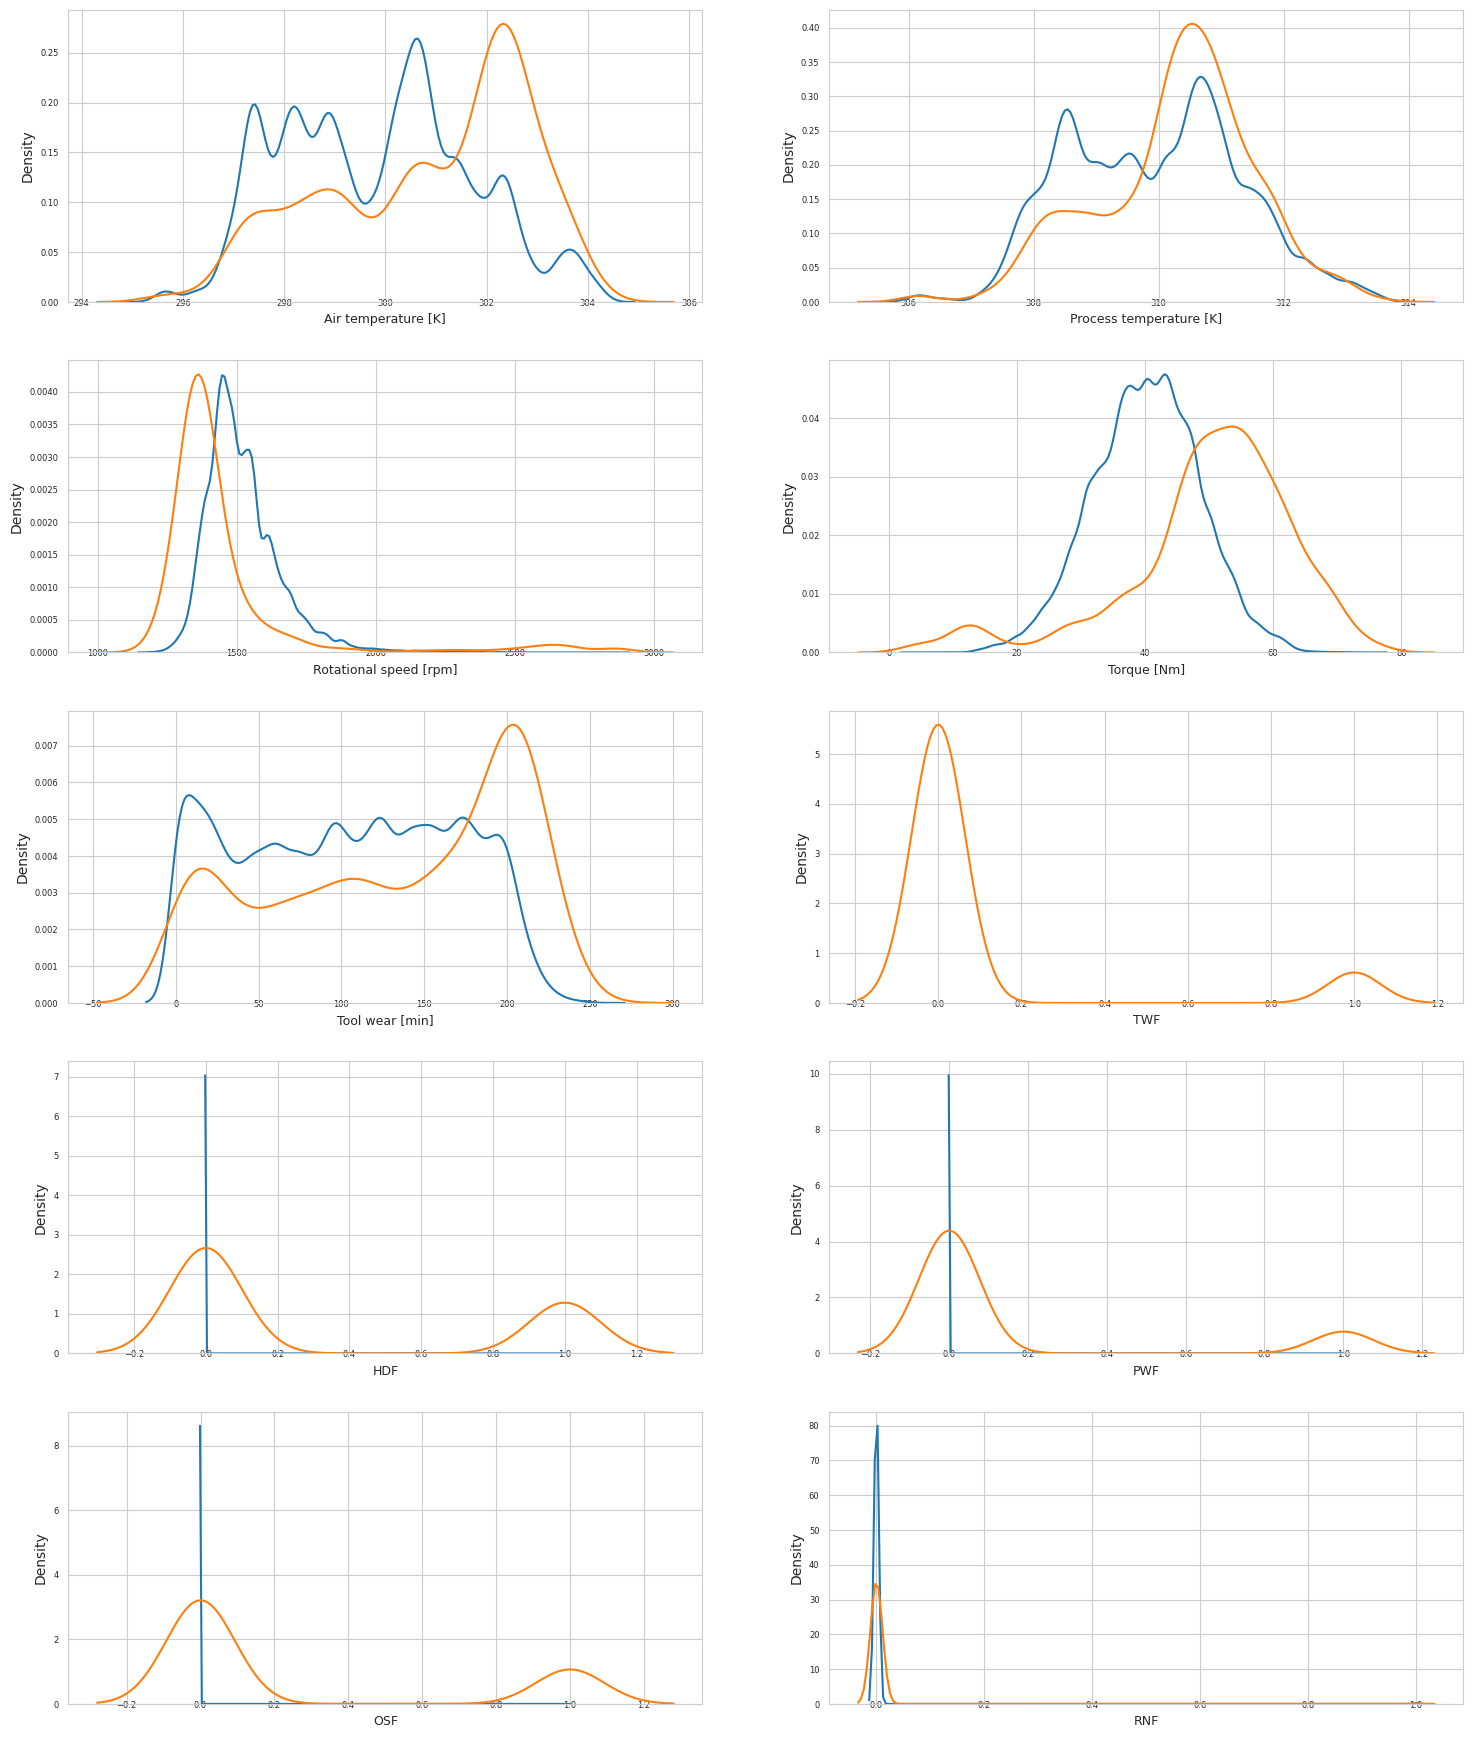

In [40]:
plot_feature_distribution(t0, t1, '0', '1', nums_columns)

There is quite a bit of variation in the 0 and 1's label data. Some features have more than 2 modes.


<Figure size 640x480 with 0 Axes>

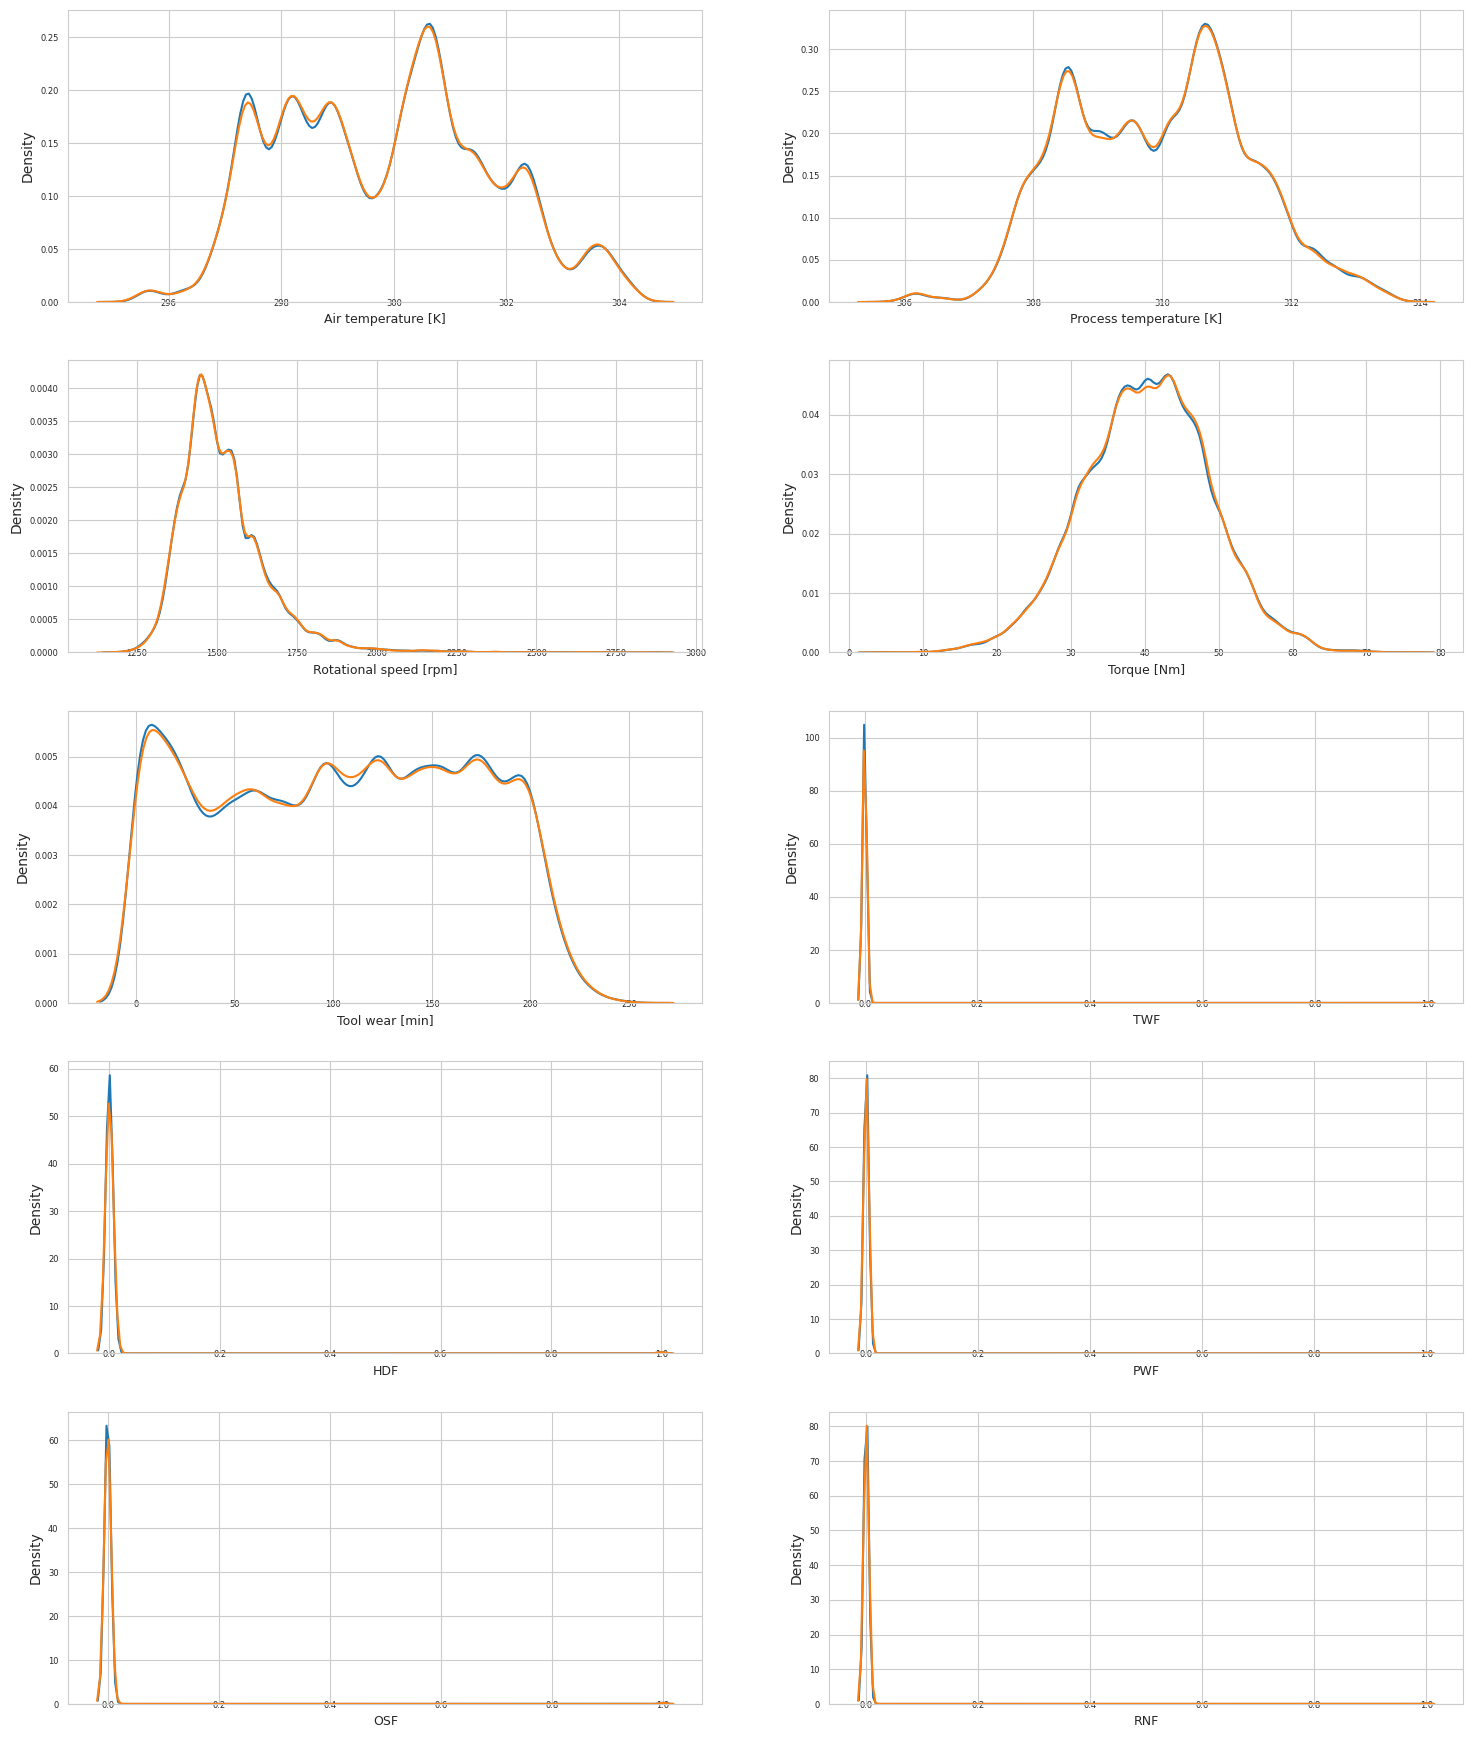

In [41]:
plot_feature_distribution(train_data, test_data, 'train', 'test', nums_columns)

Here, we see that the test and the train data come from the same distribution. This reassures us that whatever model we create will give us almost good results on test data.

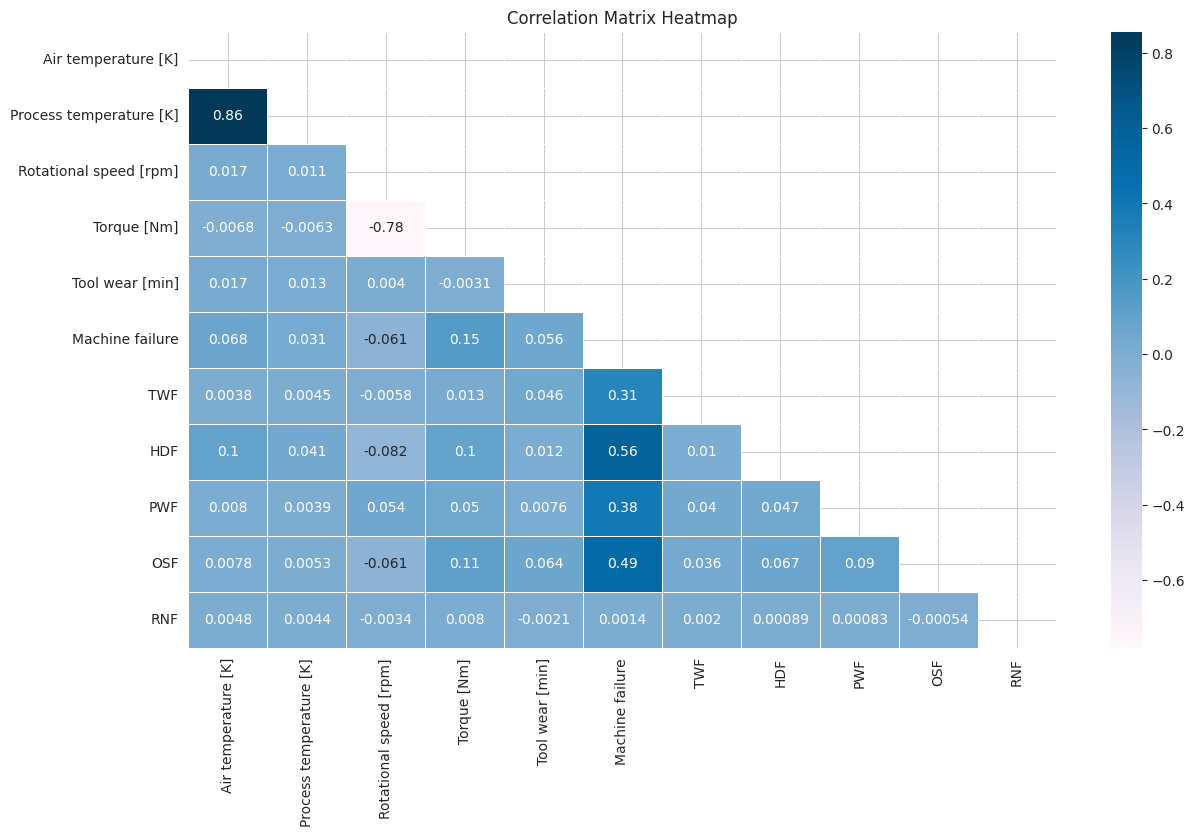

In [42]:
corr = train_data.drop('id', axis=1).corr()  # Excluding the 'id' column

# Create a correlation matrix heatmap with masking and custom colormap
fig, axes = plt.subplots(figsize=(14, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='PuBu', annot=True)

# Set the title of the heatmap
title_name = "Correlation Matrix Heatmap"
plt.title(title_name)
plt.show()

Process Temp and Air temp are highly positively correlated. WHile Rotataional speed and torque are negatively correlated.

###Data Pre-Processing

In [43]:
def mod_cat(df):

  df['Type']=df['Type'].replace({"L":0,"M":1,"H":2})
  return df

train_data=mod_cat(train_data)
test_data=mod_cat(test_data)

In [44]:
# train_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,0,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,0,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,1,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,1,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,2,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,0,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,0,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [45]:
def rename_cols(df):
    df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
    return df

train_data=rename_cols(train_data)
test_data=rename_cols(test_data)

In [46]:
# train_data.columns

Index(['id', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [47]:
# test_data.columns

Index(['id', 'Product ID', 'Type', 'Air temperature K',
       'Process temperature K', 'Rotational speed rpm', 'Torque Nm',
       'Tool wear min', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [48]:
def drop_cols(df):
    df=df.drop(["id","Product ID"],axis=1)
    return df
train_data=drop_cols(train_data)
test_data=drop_cols(test_data)

In [50]:
train_data.head()

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,0,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,0,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,1,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [52]:
test_data.head()

,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,RNF
0,0,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,0,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,0,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,1,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,1,303.4,312.3,1515,41.3,114,0,0,0,0,0


 ### BaseLine Models: XGB

In [53]:
X = train_data.drop("Machine failure",axis=1)
Y = train_data["Machine failure"]

In [54]:
import xgboost as xgb

importance_xgb = []
roc_auc_scores = []

## Running 5-fold CV
for i in range(5):
    print(f'\nIteration {i+1} begins')
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    for train_idx, test_idx in kf.split(X, Y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        xgb_model = xgb.XGBClassifier(random_state=42, verbosity=0)
        xgb_model.fit(X_train, Y_train)
        importance_xgb.append(xgb_model.feature_importances_)

        xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(Y_test, xgb_pred)
        roc_auc_scores.append(roc_auc)

        print(f'Iteration {i+1} done. ROC AUC: {roc_auc:.5f}')

avg_roc_auc = np.mean(roc_auc_scores)
avg_roc_auc_xgb = avg_roc_auc
print(f'\nThe average ROC AUC over 5 iterations is: {avg_roc_auc:.5f}')


Iteration 1 begins
Iteration 1 done. ROC AUC: 0.95762
Iteration 1 done. ROC AUC: 0.96664
Iteration 1 done. ROC AUC: 0.95716
Iteration 1 done. ROC AUC: 0.96086
Iteration 1 done. ROC AUC: 0.96070

Iteration 2 begins
Iteration 2 done. ROC AUC: 0.96348
Iteration 2 done. ROC AUC: 0.95611
Iteration 2 done. ROC AUC: 0.95894
Iteration 2 done. ROC AUC: 0.95106
Iteration 2 done. ROC AUC: 0.96369

Iteration 3 begins
Iteration 3 done. ROC AUC: 0.96121
Iteration 3 done. ROC AUC: 0.96100
Iteration 3 done. ROC AUC: 0.96267
Iteration 3 done. ROC AUC: 0.95871
Iteration 3 done. ROC AUC: 0.95894

Iteration 4 begins
Iteration 4 done. ROC AUC: 0.95895
Iteration 4 done. ROC AUC: 0.95633
Iteration 4 done. ROC AUC: 0.95485
Iteration 4 done. ROC AUC: 0.95204
Iteration 4 done. ROC AUC: 0.96797

Iteration 5 begins
Iteration 5 done. ROC AUC: 0.95570
Iteration 5 done. ROC AUC: 0.96688
Iteration 5 done. ROC AUC: 0.96674
Iteration 5 done. ROC AUC: 0.95936
Iteration 5 done. ROC AUC: 0.95763

The average ROC AUC over